In [1]:
from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from pyproj import Proj

In [79]:
# Read netcdf file
C_file = './OR_ABI-L2-CMIPC-M3C01_G16_s20183171802161_e20183171804534_c20183171805006.nc'
C = Dataset(C_file, 'r')

In [94]:
# Load the RGB arrays
R = C.variables['CMI'][:]

In [95]:
type(R)

numpy.ma.core.MaskedArray

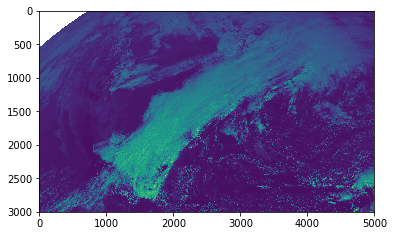

In [96]:
plt.imshow(R)

In [97]:
C.variables['CMI']

<class 'netCDF4._netCDF4.Variable'>
int16 CMI(y, x)
    _FillValue: -1
    long_name: ABI L2+ Cloud and Moisture Imagery reflectance factor
    standard_name: toa_lambertian_equivalent_albedo_multiplied_by_cosine_solar_zenith_angle
    _Unsigned: true
    sensor_band_bit_depth: 10
    valid_range: [   0 4095]
    scale_factor: 0.00031746
    add_offset: 0.0
    units: 1
    resolution: y: 0.000028 rad x: 0.000028 rad
    coordinates: band_id band_wavelength t y x
    grid_mapping: goes_imager_projection
    cell_methods: t: point area: point
    ancillary_variables: DQF
unlimited dimensions: 
current shape = (3000, 5000)
filling on

In [98]:
# Apply range limits for each channel becuase RGB values must be between 0 and 1
# Without this step, the color map won't be useful because radiances from space are much different from earth
R=np.clip(R, 0, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)

In [99]:
# Satellite height, lon, sweep
sat_h = C.variables['goes_imager_projection'].perspective_point_height
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

In [100]:
# The projection x and y coordinates
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

In [101]:
# using the Proj library to generate map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [102]:
# Convert map points to latitude and longitude
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

In [103]:
R.mask

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [104]:
# Important: convert points where R is masked to be a point in the gulf of alaska
lats[R.mask] = 57
lons[R.mask] = -152

In [105]:
lats

masked_array(
  data=[[57.        , 57.        , 57.        , ..., 51.37256315,
         51.37357212, 51.37458208],
        [57.        , 57.        , 57.        , ..., 51.3534121 ,
         51.35441959, 51.35542809],
        [57.        , 57.        , 57.        , ..., 51.3342741 ,
         51.33528013, 51.33628717],
        ...,
        [15.13571553, 15.13533578, 15.13495625, ..., 14.65270751,
         14.65280726, 14.65290709],
        [15.12574764, 15.1253682 , 15.12498898, ..., 14.64311774,
         14.64321742, 14.64331717],
        [15.11578057, 15.11540144, 15.11502253, ..., 14.63352864,
         14.63362824, 14.63372792]],
  mask=False,
  fill_value=1e+20)

In [106]:
# Make a new map object for CONUS Lambert Conformal Conic Projection
mH = Basemap(projection='lcc', area_thresh=5000, \
             width=1800*5000, height=1060*5000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

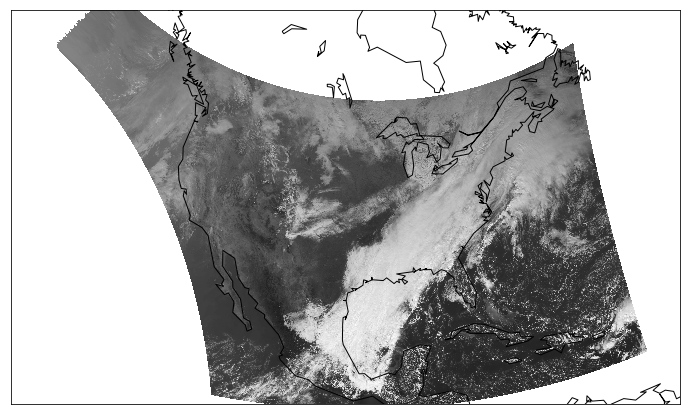

In [107]:
# Plot the image
plt.figure(figsize=[12, 9.5])
# Using pcolormesh instead of imshow because we need to use lat/lon arrays in this case
newmap = mH.pcolormesh(lons, lats, R, cmap='Greys_r', linewidth=0, latlon=True)
mH.drawcoastlines()

In [108]:
# Plotting a sub-section...this has problems 
mZ = Basemap(projection='cyl', area_thresh=5000,\
             llcrnrlon=-160., llcrnrlat=10.,\
             urcrnrlon=-50., urcrnrlat=60.,)

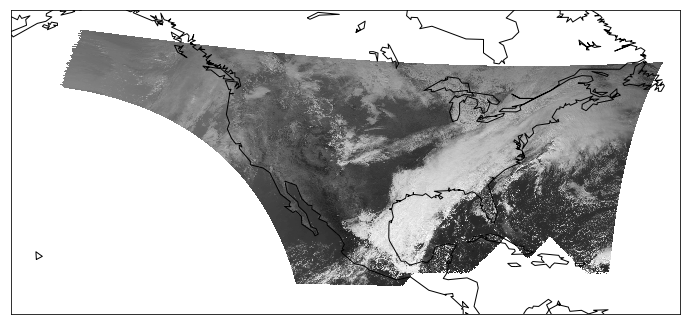

In [109]:
plt.figure(figsize=[12, 9.5])
newmap = mZ.pcolormesh(lons, lats, R, cmap='Greys_r', linewidth=0, latlon=True)
mZ.drawcoastlines()